In [1]:
import pandas as pd


df = pd.read_csv('heart-failure-clean.csv')
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,0,140,289,0,0,172,0,0.0,0,0
1,49,0,1,160,180,0,0,156,0,1.0,1,1
2,37,1,0,130,283,0,1,98,0,0.0,0,0
3,48,0,2,138,214,0,0,108,1,1.5,1,1
4,54,1,1,150,195,0,0,122,0,0.0,0,0


# definindo o melhor valor de K para kmeans

In [2]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [3]:

df_km = df[sorted(df.columns)]

df_km = df_km.drop('HeartDisease', axis=1)


In [4]:
wcss = []
sil = []
cb = []

for i in range(1, 11):
    kmeans = KMedoids(n_clusters= i ,random_state=42)
    kmeans.fit(df_km)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(df_km, labels, metric = 'euclidean')) if i!=1 else sil.append(0)
                                                                                              
    cb.append(calinski_harabasz_score(df_km, labels))  if i!=1 else cb.append(0)

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0, 1))

wcss = scaler.fit_transform( np.array(wcss).reshape(-1,1))
cb = scaler.fit_transform(np.array(cb).reshape(-1,1))
sil = scaler.fit_transform(np.array(sil).reshape(-1,1))

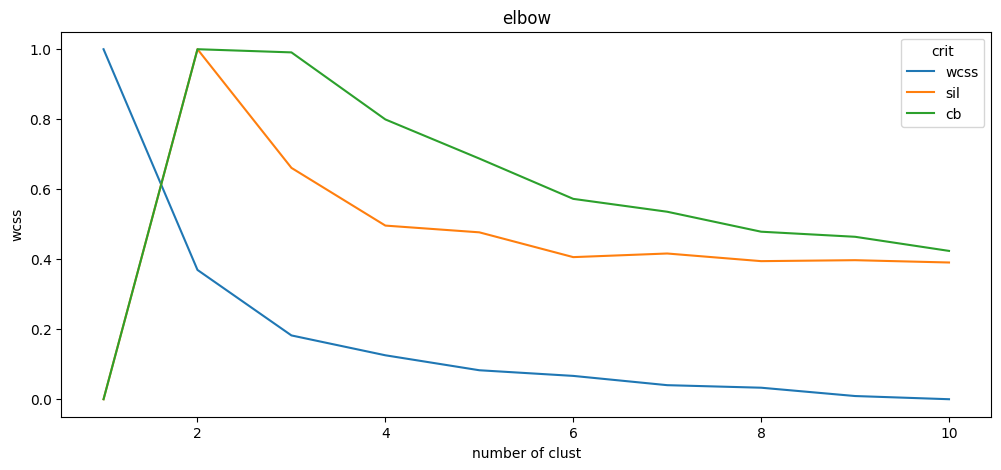

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(range(1,11), wcss, label="wcss")
plt.plot(range(1,11), sil, label="sil")
plt.plot(range(1,11), cb , label="cb")
plt.legend(title = "crit") 
plt.title('elbow')
plt.xlabel('number of clust')
plt.ylabel('wcss')
plt.show()

wcss pode ser 3 ou 4. Baseado no metodo da silhoeta que mede o qual proximos são os pontos intra cluster e calinski harabaz que mede o qual coesos entre si são os pontos em comparação com o quão  não coesos interclusteres são.

In [7]:
heart_disease_kmeans = KMedoids(n_clusters= 2 ,random_state=45)
heart_disease_kmeans.fit(df_km)

KMedoids(n_clusters=2, random_state=45)

## o cluster e correlação com diagnostico

In [8]:
df_km['cluster'] = heart_disease_kmeans.predict(df_km)
df_km['HeartDisease'] = df['HeartDisease']


In [9]:
# Check if indices are the same
if df.index.equals(df_km.index):
    df_km['HeartDisease'] = df['HeartDisease']
else:
    print("The DataFrames are not aligned!")


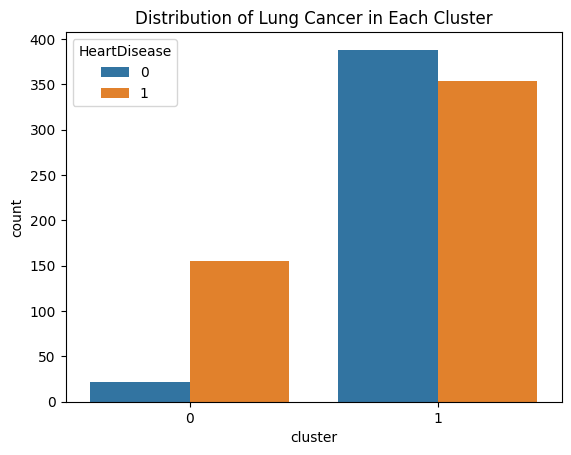

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='cluster', hue='HeartDisease', data=df_km)
plt.title('Distribution of Lung Cancer in Each Cluster')
plt.show()


In [11]:
pd.crosstab(df_km['cluster'], df_km['HeartDisease'])


HeartDisease,0,1
cluster,,
0,22,155
1,388,353


In [12]:
df_km.groupby('cluster')['HeartDisease'].agg(['count', 'mean'])


,count,mean
cluster,,
0,177,0.875706
1,741,0.476383


In [13]:

import pickle
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from basemodel import Basemodel

model = Basemodel(heart_disease_kmeans)

with open('heart-failure-kmedoids.pkl', 'wb') as file:
    pickle.dump(heart_disease_kmeans, file)
